In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

from google.colab import files
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('/content/ALLFLOWMETER_HIKARI2021.csv')

In [5]:
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])
# Only want to look at probing for the problem statement and there is a decent amount of data for this
df[df['traffic_category'] == 'Probing']
df = df[(df['traffic_category'] == 'Benign') | (df['traffic_category'] == 'Probing')]
df = df.drop(columns=['originp', 'responp']) # identifiers that we don't want to use for the modeling stage
df = df.select_dtypes(include=[np.number])

In [6]:
df

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,Label
181180,5359.472365,127,0,127,0,0.023696,0.000000,0.023696,0.000000,1016,...,0.0,4.206444e+07,4.307476e+07,5.359472e+09,4.253549e+07,291118.988688,0,0,0,0
181181,6811.639999,161,0,161,0,0.023636,0.000000,0.023636,0.000000,1288,...,0.0,4.207135e+07,4.306212e+07,6.811640e+09,4.257275e+07,285948.485423,0,0,0,0
181182,3277.740273,78,0,78,0,0.023797,0.000000,0.023797,0.000000,624,...,0.0,4.206999e+07,4.306987e+07,3.277740e+09,4.256806e+07,297213.340679,0,0,0,0
181183,0.000182,1,1,0,0,5489.926702,5489.926702,10979.853403,1.000000,40,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,29200,0,29200,0
181184,0.000089,1,1,0,0,11214.716578,11214.716578,22429.433155,1.000000,40,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,29200,0,29200,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551994,0.249909,10,14,3,8,40.014577,56.020408,96.034986,1.400000,328,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,29200,65160,402,1
551995,0.253536,9,12,3,7,35.497919,47.330559,82.828479,1.333333,296,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,29200,65160,402,1
551996,0.258555,9,12,3,7,34.808850,46.411800,81.220650,1.333333,296,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,29200,65160,402,1
551997,0.244943,10,13,3,8,40.825841,53.073593,93.899434,1.300000,328,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,29200,65160,402,1


# Identification of num_features to use

Strategy: I will use a basic logistic regression model on multiple SelectKBest k values to see which level of values results in the highest accuracy. This way, I have a scientific methodology as to how I am selecting the number of features that I will be using for my exploratory data analysis and modeling stages.

In [7]:
def k_scores(df:pd.DataFrame):
  """Returns a DataFrame that shows each iteration of K, along with train and test accuracy on a basic LogisticRegression model.
  This DataFrame is best used to inform feature selection and understanding how many features to use for a given
  classification problem."""

  # Initialize Output DataFrame
  scores_df = pd.DataFrame(columns=[
                                    'k',
                                    'train_acc',
                                    'test_acc'
  ])

  for i in np.arange(1, 80, 10): # Setting in steps of 10 for time complexity
    # For each iteration, running SelectKBest with however many features as reflected in the iteration of the for loop
    fvalue_selector = SelectKBest(f_classif, k=i) # selecting f-score, classification problem
    X_best_features = fvalue_selector.fit_transform(
      df.drop(columns=['Label']), df['Label'])
    
    # Initialize Logistic Regression
    lr = LogisticRegression(
        max_iter=10000, 
        random_state=42)
    
    # Defining X and y
    X = pd.DataFrame(columns=df.columns[fvalue_selector.get_support(indices=True)].tolist(), data=X_best_features)
    y = df['Label']

    # train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.3,
        random_state=42,
        stratify=y
    )

    # Oversample with SMOTE
    # Preliminary EDA showed a drastic class imbalance
    sm = SMOTE()
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

    # Initialize MinMaxScaler
    # Running through a data science workflow all of the way through showed no sign of normal distributions in the data
    # Thus the need to scale data with MinMax
    mms = MinMaxScaler()
    Xs_train = mms.fit_transform(X_train_sm)
    Xs_test = mms.transform(X_test)

    # Fit and score
    lr.fit(Xs_train, y_train_sm)
    train_acc = lr.score(Xs_train, y_train_sm)
    test_acc = lr.score(Xs_test, y_test)

    # Add to scores_df DataFrame
    scores_df.loc[i] = [
                        (i),
                        train_acc,
                        test_acc
    ]

  # scores_df
  return scores_df.sort_values(by=['test_acc'], ascending=False)

In [8]:
df_kbest = k_scores(df)

In [9]:
df_kbest

,k,train_acc,test_acc
71,71.0,0.907657,0.832048
41,41.0,0.907504,0.832003
51,51.0,0.907433,0.831940
61,61.0,0.907478,0.831940
31,31.0,0.907367,0.831365
21,21.0,0.907560,0.831275
11,11.0,0.897320,0.813306
1,1.0,0.847096,0.712763


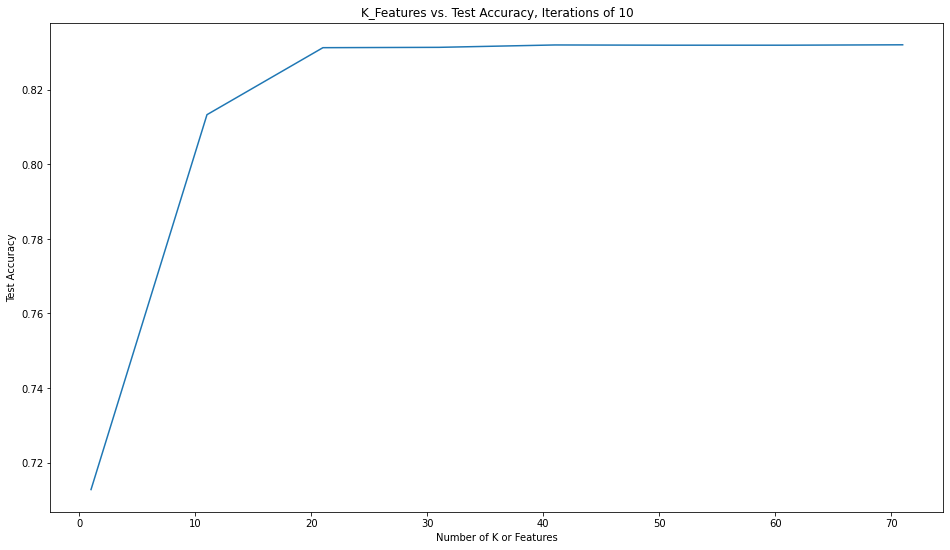

In [15]:
plt.figure(figsize=(16,9))
sns.lineplot(data=df_kbest, x='k', y='test_acc')
plt.title('K_Features vs. Test Accuracy, Iterations of 10')
plt.xlabel('Number of K or Features')
plt.ylabel('Test Accuracy');

Based on this function, there are a lot of options for the K value that we can use. Beyond 20 features, it doesn't appear to have an effect on test accuracy. The next step is using the K value to create a new dataframe and use it for our EDA and modeling steps.

In [14]:
fvalue_selector = SelectKBest(f_classif, k=20)
X_best_features = fvalue_selector.fit_transform(
df.drop(columns=['Label']), df['Label'])

df_k_20 = pd.DataFrame(columns=df.columns[fvalue_selector.get_support(indices=True)].tolist(), data=X_best_features)
df_k_20['label'] = list(df['Label'])

df_k_20.to_csv('output.csv') 
files.download('output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>